In [1]:
from sotip import *
import numpy as np
import scanpy as sc


In [2]:
adata = sc.read_h5ad('spagcn_result/MIBI_p4_scagcn_20211201.h5ad')

In [3]:
adata.var_names

Index(['Beta catenin', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD20', 'CD209',
       'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8',
       'dsDNA', 'EGFR', 'FoxP3', 'H3K27Me3', 'H3K9ac', 'HLA-DR', 'HLA_Class_1',
       'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO', 'p53',
       'Pan-Keratin', 'PD-L1', 'PD1', 'phospho-S6', 'SMA', 'Vimentin'],
      dtype='object')

In [4]:
me_array = np.array(adata[:,'H3K27Me3'].X)
ac_array = np.array(adata[:,'H3K9ac'].X)
adata_add = ad.AnnData((me_array+1)/(ac_array+1))
adata_add.var_names = ['Me/Ac']
adata_add.obs_names = adata.obs_names
adata = ad.concat([adata,adata_add],axis=1,merge='first')

In [8]:
adata.uns['pred_colors'] = ['r','k']

In [9]:
rename_dict = {
    1:'immune',
    0:'tumor'
}
adata.obs['pred'] = adata.obs['pred'].cat.rename_categories(rename_dict)

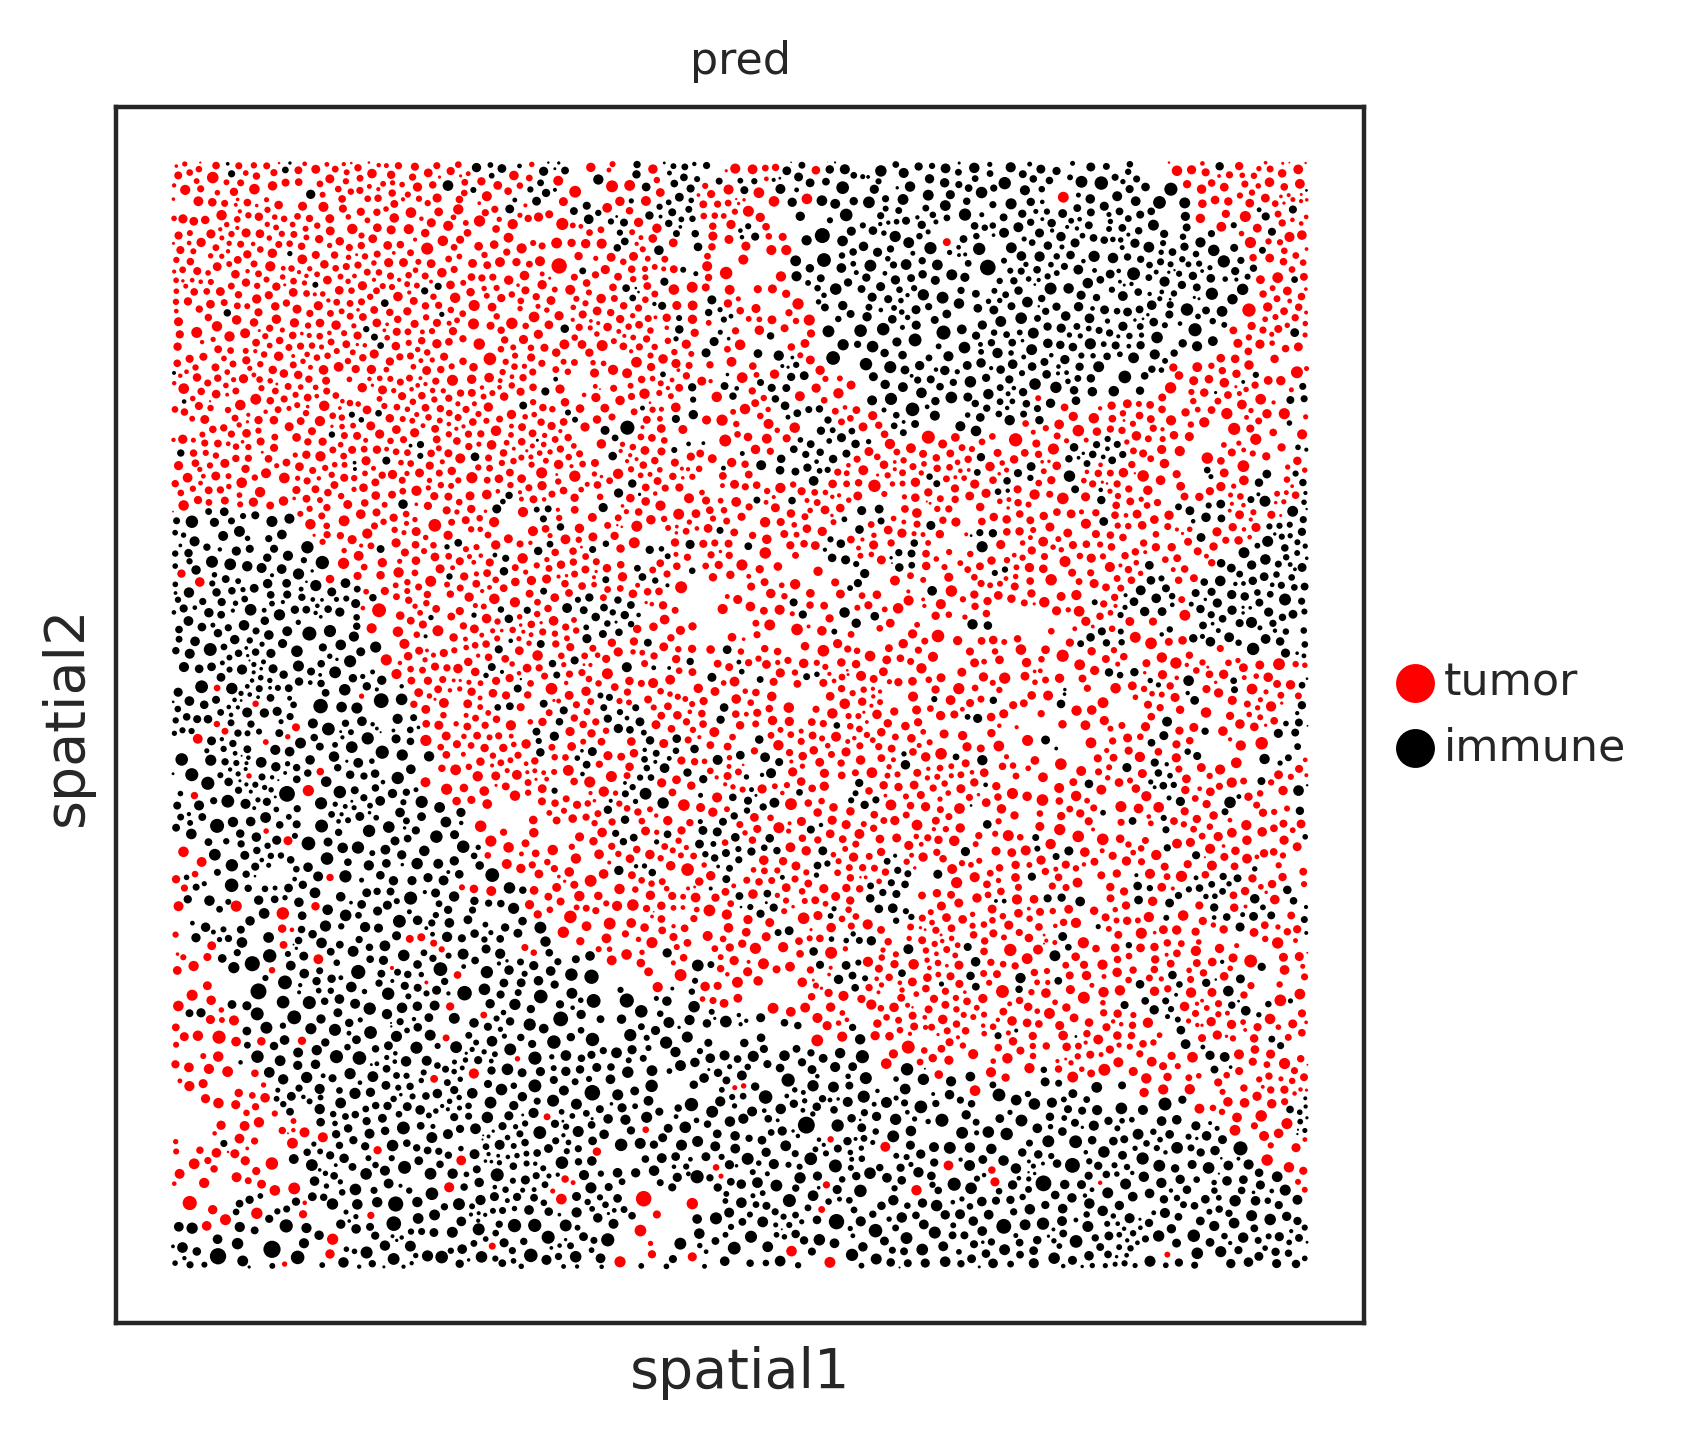

In [10]:
sc.pl.embedding(adata,basis='spatial',color=['pred'],size=adata.obs['cell_size']/50)

In [11]:
# 分别计算所有细胞到这两类区域的最短距离
spatial_mat = adata.obsm['spatial']
dist_mat = squareform(pdist(spatial_mat))

In [12]:
for region in adata.obs['pred'].cat.categories:
    cur_idx = np.where(adata.obs['pred']==region)[0]
    cur_dist_obs = f'min_dist_to_{region}'
    cur_min_dist = np.min(dist_mat[:,cur_idx],axis=1)
    adata.obs[cur_dist_obs] = cur_min_dist

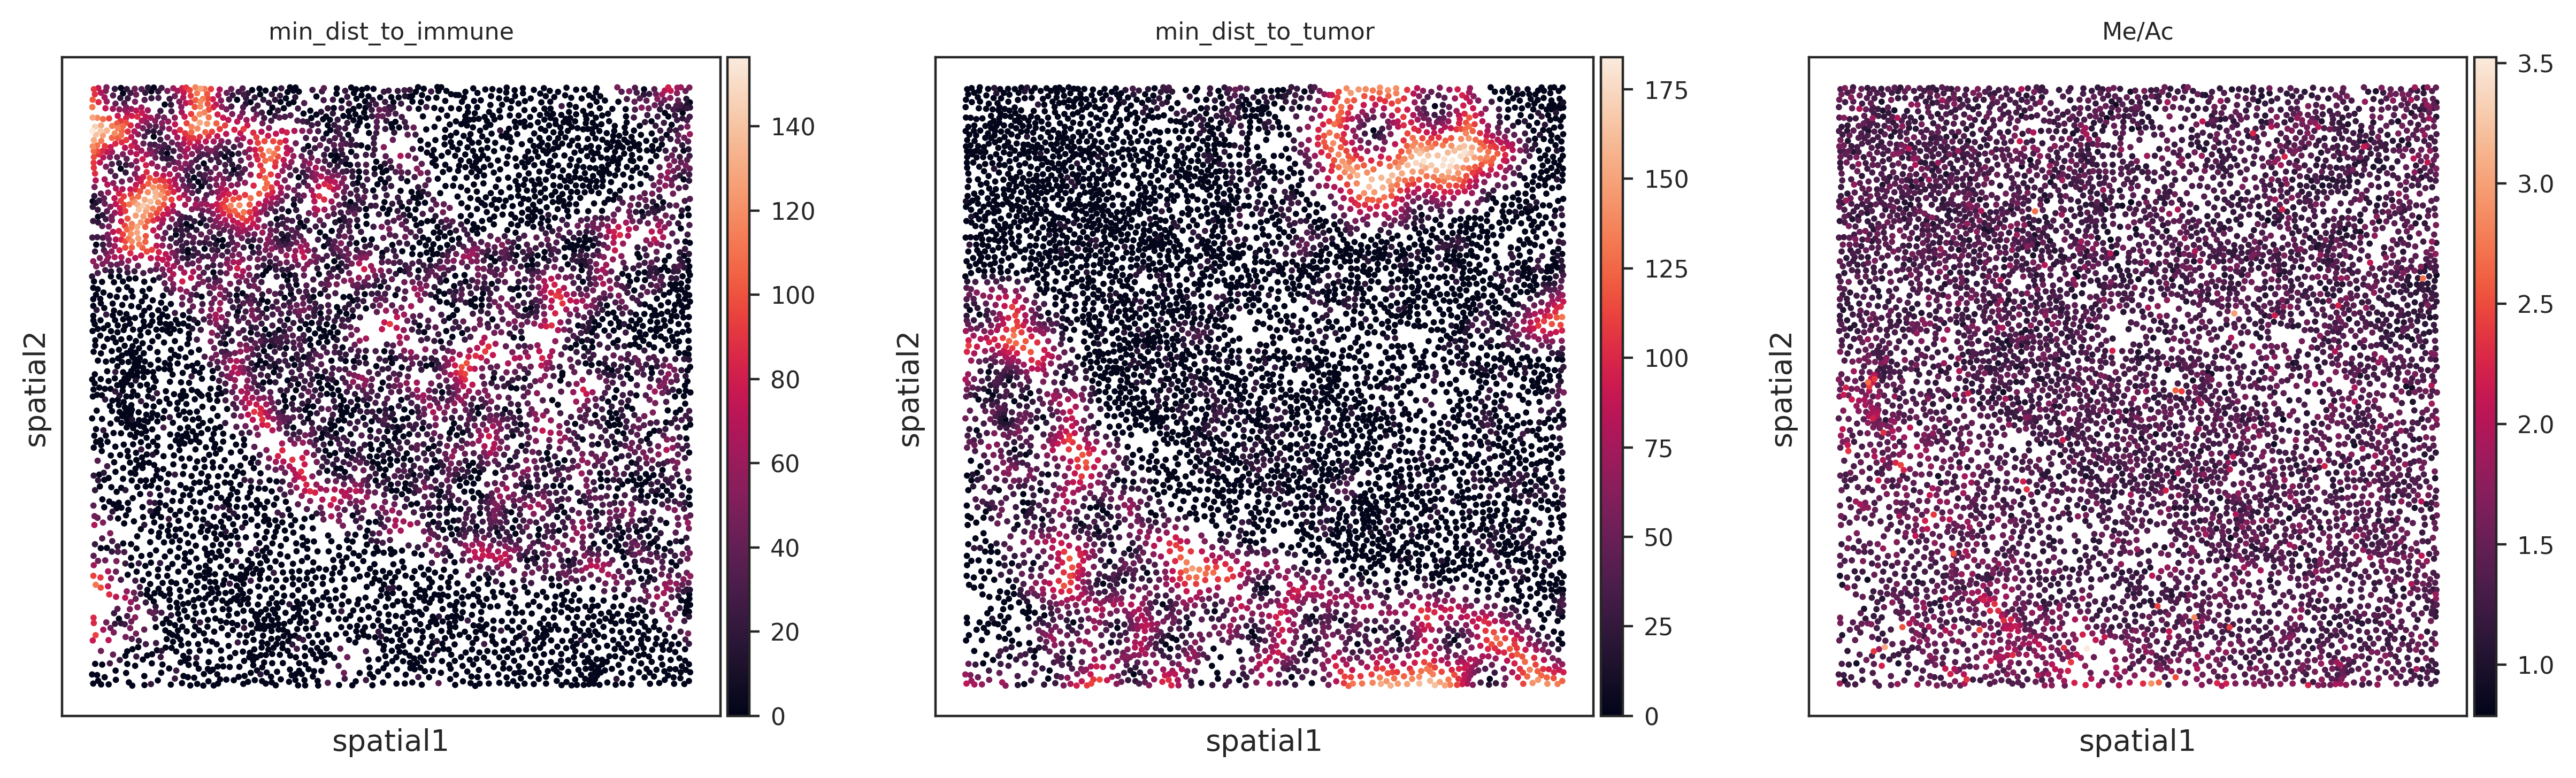

In [13]:
sc.pl.embedding(adata,basis='spatial',color=['min_dist_to_immune','min_dist_to_tumor','Me/Ac'])

# polarize in tumor

In [14]:

# from original paper
boundary_sz_pixel = 100

In [15]:
boundary_array = np.array(adata.obs['pred'].copy())
min_dist_to_immune_array = np.array(adata.obs['min_dist_to_immune'].copy())
min_dist_to_tumor_array = np.array(adata.obs['min_dist_to_tumor'].copy())

In [16]:
boundary_array[(boundary_array=='tumor') & (min_dist_to_immune_array<=boundary_sz_pixel)] = 'boundary_tumor'
boundary_array[(boundary_array=='immune') & (min_dist_to_tumor_array<=boundary_sz_pixel)] = 'boundary_immune'

In [17]:
adata.obs['boundary'] = boundary_array

/root/anaconda3/envs/SOTIP/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'boundary' as categorical


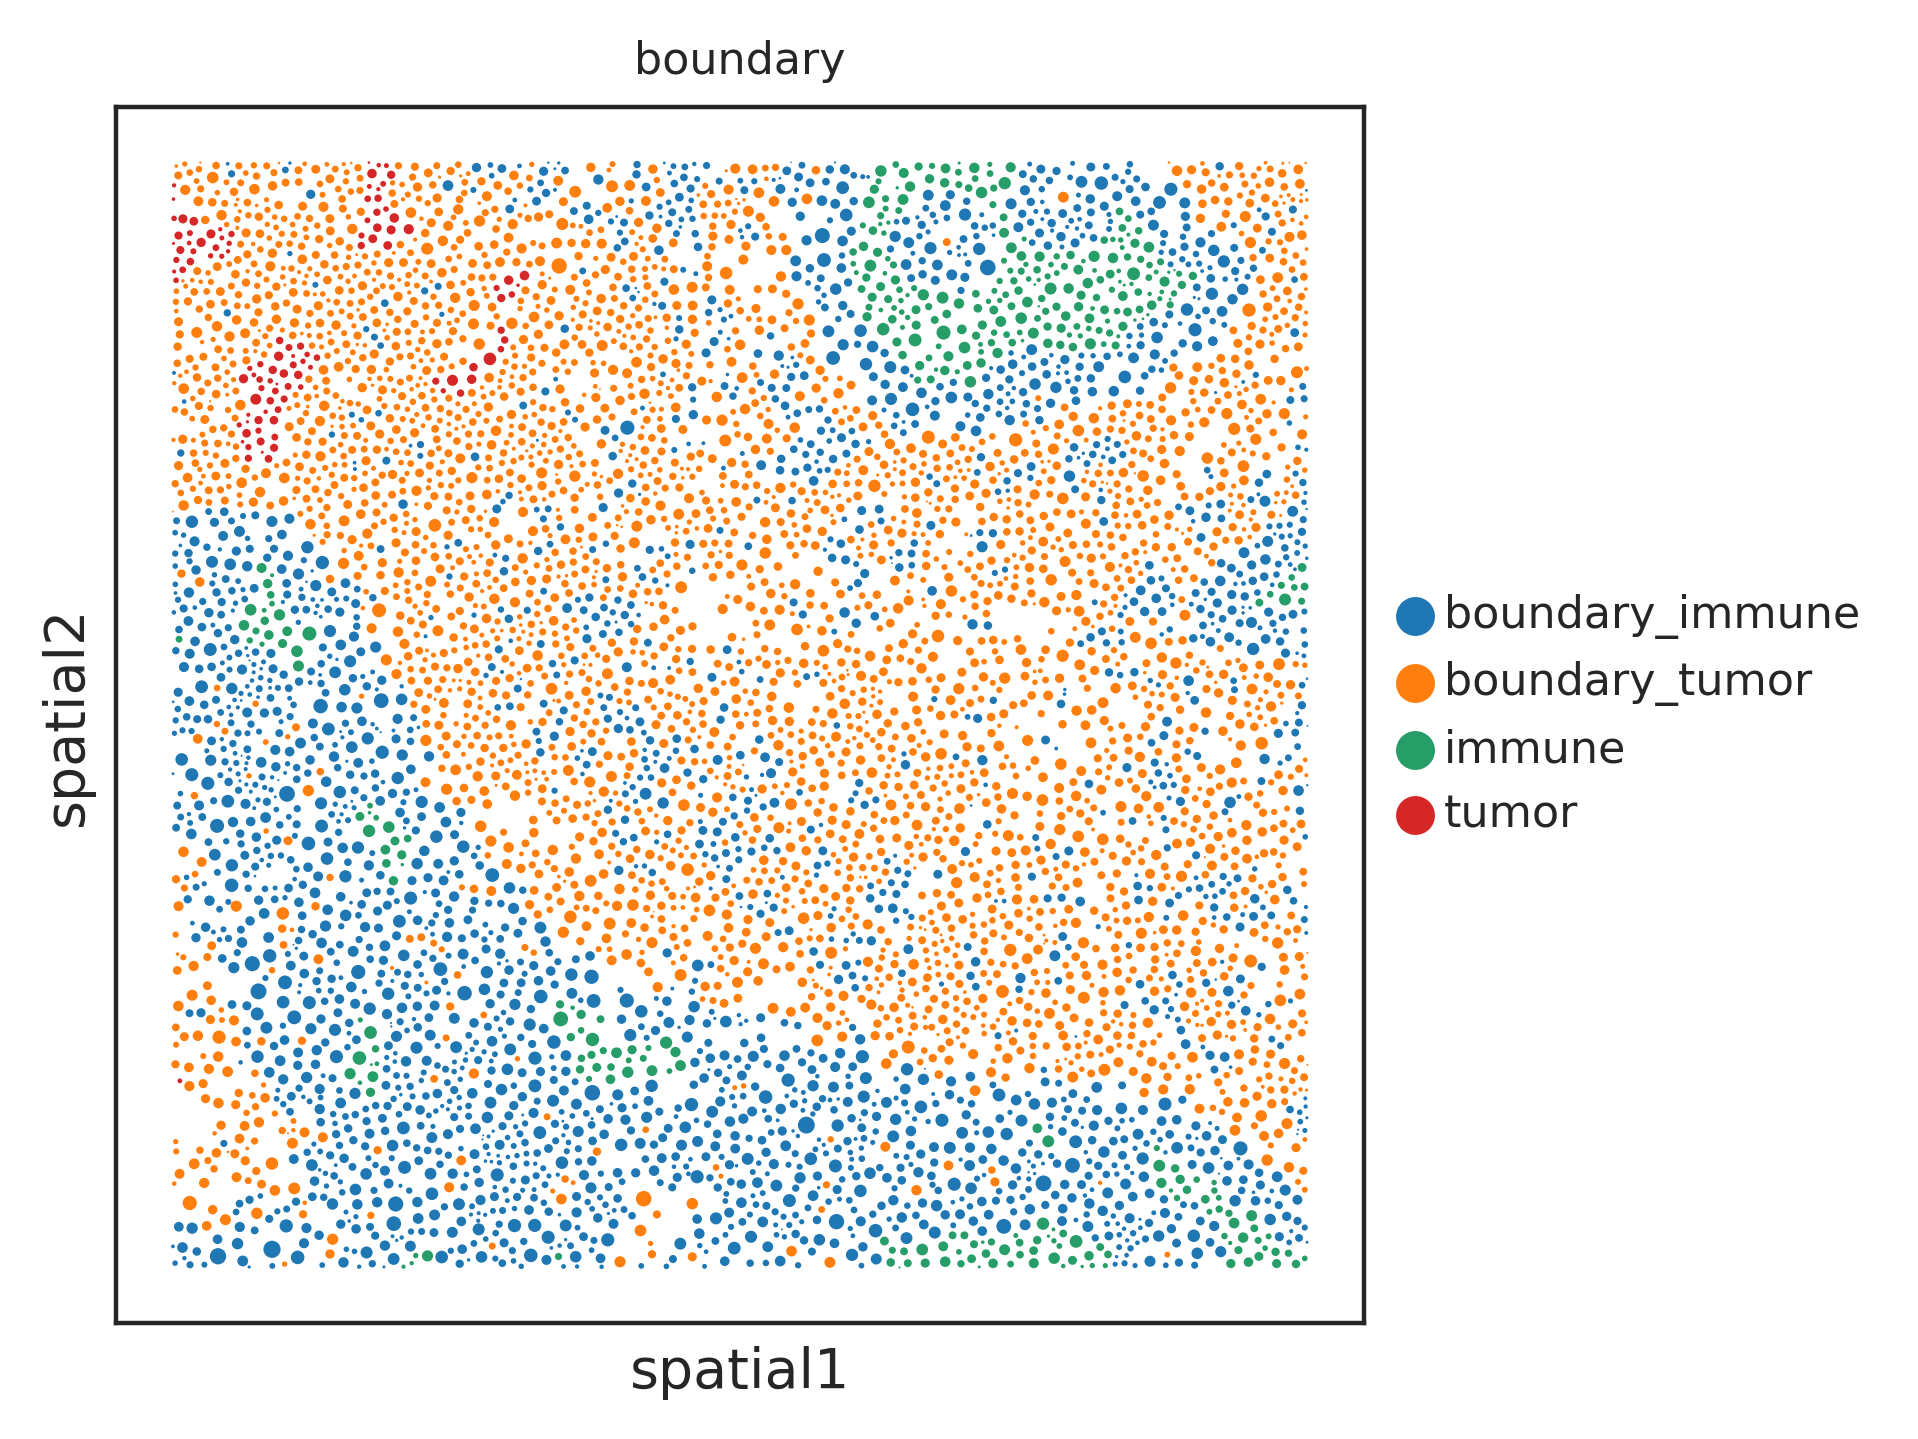

In [18]:
sc.pl.embedding(adata,basis='spatial',color=['boundary'],size=adata.obs['cell_size']/50)

In [19]:

def test_polar(adata,obs,between,protein,var):
    array_0 = np.array(adata[adata.obs[obs]==between[0],protein].X)
    array_1 = np.array(adata[adata.obs[obs]==between[1],protein].X)
    pv = ranksums(array_0,array_1,alternative='two-sided')[1]
    adata.var[var][np.where(adata.var_names==protein)[0]] = pv
    
    
    
    return pv

# porlar to tumor, ranksum

In [20]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_tumor','tumor']
var_name = 'spagcn_polar_in_tumor'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [21]:
from pingouin import multicomp
obs = 'boundary'
between = ['boundary_immune','immune']
var_name = 'spagcn_polar_in_immune'
adata.var[var_name] = np.zeros(shape=(adata.shape[1]))
for protein in adata.var_names:
    test_polar(adata,obs,between,protein,var_name)
pv_list = np.array(adata.var[var_name])
_,pv_adj = multicomp(pv_list,method='fdr_bh')
adata.var[f'{var_name}_bh'] = pv_adj

In [22]:
adata.var

spagcn_polar_in_tumor  spagcn_polar_in_tumor_bh  \
Beta catenin           9.936742e-02              2.042552e-01   
CD11b                  5.614822e-01              9.032540e-01   
CD11c                  7.488152e-08              3.958023e-07   
CD138                  4.066811e-07              1.880900e-06   
CD16                   4.741518e-07              1.949291e-06   
CD20                   3.531245e-15              4.700736e-14   
CD209                  6.500243e-01              9.097509e-01   
CD3                    6.686561e-13              6.185069e-12   
CD31                   1.060686e-01              2.065546e-01   
CD4                    2.573280e-08              1.586856e-07   
CD45                   3.811407e-15              4.700736e-14   
CD45RO                 3.937949e-11              2.914083e-10   
CD56                   9.284871e-01              9.815435e-01   
CD63                   5.589331e-01              9.032540e-01   
CD68                   6.471357e-01              9.097509e-01   
CD8                    3.895957e-05              1.201253e-04   
dsDNA                  7.130480e-01              9.097509e-01   
EGFR                   9.168285e-01              9.815435e-01   
FoxP3                  6.915456e-01              9.097509e-01   
H3K27Me3               5.792580e-06              2.143254e-05   
H3K9ac                 1.712538e-03              4.525993e-03   
HLA-DR                 2.317828e-05              7.796329e-05   
HLA_Class_1            7.576870e-20              2.803442e-18   
IDO                    3.226917e-01              5.969797e-01   
Keratin17              6.863096e-01              9.097509e-01   
Keratin6               9.994843e-01              9.994843e-01   
Ki67                   5.904294e-01              9.097509e-01   
Lag3                   7.579223e-01              9.347708e-01   
MPO                    8.522586e-01              9.555627e-01   
p53                    9.920436e-01              9.994843e-01   
Pan-Keratin            8.380197e-01              9.555627e-01   
PD-L1                  3.746787e-01              6.601481e-01   
PD1                    3.199115e-04              9.105175e-04   
phospho-S6             2.898126e-02              7.148710e-02   
SMA                    8.129629e-01              9.555627e-01   
Vimentin               4.879208e-02              1.128317e-01   
Me/Ac                  5.361157e-02              1.166840e-01   

              spagcn_polar_in_immune  spagcn_polar_in_immune_bh  
Beta catenin            2.729072e-14               2.019513e-13  
CD11b                   8.021279e-01               9.573785e-01  
CD11c                   3.139472e-01               5.181058e-01  
CD138                   2.404618e-03               5.931390e-03  
CD16                    5.177594e-03               1.197319e-02  
CD20                    2.449332e-02               5.034739e-02  
CD209                   8.941839e-01               9.905580e-01  
CD3                     1.215517e-05               3.747845e-05  
CD31                    2.046081e-03               5.407500e-03  
CD4                     6.959368e-05               1.980743e-04  
CD45                    3.024023e-23               5.594443e-22  
CD45RO                  3.264195e-07               1.341947e-06  
CD56                    1.000000e+00               1.000000e+00  
CD63                    4.183165e-01               6.191084e-01  
CD68                    1.206810e-11               6.378853e-11  
CD8                     2.198493e-01               4.067212e-01  
dsDNA                   4.810884e-07               1.780027e-06  
EGFR                    2.554879e-01               4.501453e-01  
FoxP3                   9.507360e-01               1.000000e+00  
H3K27Me3                6.053302e-13               3.732870e-12  
H3K9ac                  1.286713e-02               2.800493e-02  
HLA-DR                  1.603484e-10               7.416112e-10  
HLA_Class_1             8

In [24]:
gt_polarized_tumor_all = ['EGFR','Beta catenin','Pan-Keratin','p53','Ki67','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_all = ['CD20','CD209','CD11b','HLA-DR','FoxP3','Ki67','CD56','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']



In [23]:
gt_polarized_tumor_p4 = ['EGFR','Beta catenin','Me/Ac','Keratin6','Keratin17','PD-L1','HLA-DR']
gt_polarized_immune_p4 = ['CD20','CD209','HLA-DR','FoxP3','PD-L1','IDO','CD45RO','CD4','CD11c','CD68']
# gt_polarized_tumor_p9 = ['Me/Ac','PD-L1','HLA-DR']
# gt_polarized_immune_p9 = ['CD20','CD11b','HLA-DR','MPO','Lag3','PD-L1','IDO','CD45RO','PD1','CD8','CD3','CD4','CD11c','CD16','CD68']

In [24]:
for i in gt_polarized_tumor_p4:
    if i not in adata.var_names:
        print(i)

In [25]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_tumor'] = gt_polarized_array
adata.var['gt_polarized_tumor'][adata.var_names.isin(gt_polarized_tumor_p4)] = 1

In [26]:
gt_polarized_array = np.zeros(shape=(adata.shape[1],))
adata.var['gt_polarized_immune'] = gt_polarized_array
adata.var['gt_polarized_immune'][adata.var_names.isin(gt_polarized_immune_p4)] = 1

In [27]:
adata.write_h5ad('spagcn_polar_test_p4.h5ad')